## 1. Setup & Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings

# Optuna
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour,
    plot_slice
)

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MLflow
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Paths
PROCESSED_DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')

print("✅ Setup complete!")


✅ Setup complete!


In [2]:
# Check for XGBoost and LightGBM
try:
    import xgboost as xgb
    print(f"✅ XGBoost: {xgb.__version__}")
    HAS_XGB = True
except ImportError:
    print("⚠️ XGBoost not installed")
    HAS_XGB = False

try:
    import lightgbm as lgb
    print(f"✅ LightGBM: {lgb.__version__}")
    HAS_LGB = True
except ImportError:
    print("⚠️ LightGBM not installed")
    HAS_LGB = False

print(f"✅ Optuna: {optuna.__version__}")


✅ XGBoost: 3.0.0
✅ LightGBM: 4.6.0
✅ Optuna: 4.6.0


## 2. Load Data & Previous Results

In [3]:
# Load processed data
train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

# Load feature config
feature_config = joblib.load(PROCESSED_DATA_DIR / 'feature_config.joblib')
ALL_FEATURES = feature_config['all_features']
TARGET = feature_config['target']

print(f"📊 Data loaded:")
print(f"   Train: {train_df.shape}")
print(f"   Val: {val_df.shape}")
print(f"   Test: {test_df.shape}")


📊 Data loaded:
   Train: (11168247, 19)
   Val: (2393196, 19)
   Test: (2393196, 19)


In [4]:
# Prepare features and target
X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET]

X_val = val_df[ALL_FEATURES]
y_val = val_df[TARGET]

X_test = test_df[ALL_FEATURES]
y_test = test_df[TARGET]

print(f"✅ Features: {len(ALL_FEATURES)}")


✅ Features: 18


In [5]:
# Load previous best model metadata dari Step 3
try:
    model_metadata = joblib.load(MODELS_DIR / 'model_metadata.joblib')
    BASELINE_MODEL_NAME = model_metadata['model_name']
    BASELINE_VAL_MAE = model_metadata['val_metrics']['mae']
    print(f"📊 Baseline Model: {BASELINE_MODEL_NAME}")
    print(f"   Baseline Val MAE: ${BASELINE_VAL_MAE:.4f}")
except FileNotFoundError:
    print("⚠️ No previous model found. Using default baseline.")
    BASELINE_MODEL_NAME = 'random_forest'
    BASELINE_VAL_MAE = None


📊 Baseline Model: random_forest
   Baseline Val MAE: $1.1288


In [6]:
# Sampling untuk tuning lebih cepat (opsional)
# Data besar bisa memakan waktu lama untuk tuning

SAMPLE_SIZE = 200000  # Set None untuk full data

if SAMPLE_SIZE and len(X_train) > SAMPLE_SIZE:
    print(f"⚠️ Sampling {SAMPLE_SIZE:,} rows untuk tuning...")
    sample_idx = np.random.choice(len(X_train), SAMPLE_SIZE, replace=False)
    X_train_tune = X_train.iloc[sample_idx]
    y_train_tune = y_train.iloc[sample_idx]
    
    val_sample_size = SAMPLE_SIZE // 4
    val_sample_idx = np.random.choice(len(X_val), min(val_sample_size, len(X_val)), replace=False)
    X_val_tune = X_val.iloc[val_sample_idx]
    y_val_tune = y_val.iloc[val_sample_idx]
else:
    X_train_tune = X_train
    y_train_tune = y_train
    X_val_tune = X_val
    y_val_tune = y_val

print(f"   Tuning data: {len(X_train_tune):,} train, {len(X_val_tune):,} val")


⚠️ Sampling 200,000 rows untuk tuning...
   Tuning data: 200,000 train, 50,000 val


## 3. Setup MLflow

In [7]:
# Setup MLflow
MLFLOW_TRACKING_URI = "../mlruns"
EXPERIMENT_NAME = "nyc-taxi-fare-tuning"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✅ MLflow experiment: {EXPERIMENT_NAME}")


✅ MLflow experiment: nyc-taxi-fare-tuning


## 4. Define Objective Functions

Kita akan tune model terbaik dari Step 3 berdasarkan hasil yang tersimpan di `model_metadata.joblib`. Ini memastikan konsistensi workflow MLOps.

In [8]:
# Select model to tune - berdasarkan hasil terbaik dari Step 3
# Gunakan model yang tersimpan di model_metadata.joblib

MODEL_TO_TUNE = BASELINE_MODEL_NAME
print(f"🎯 Model to tune: {MODEL_TO_TUNE} (from Step 3 results)")


🎯 Model to tune: random_forest (from Step 3 results)


In [9]:
def objective_random_forest(trial):
    """
    Optuna objective function for Random Forest.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.7, 1.0]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train_tune, y_train_tune)
    
    y_pred = model.predict(X_val_tune)
    mae = mean_absolute_error(y_val_tune, y_pred)
    
    return mae


def objective_lightgbm(trial):
    """
    Optuna objective function for LightGBM.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train_tune, y_train_tune,
        eval_set=[(X_val_tune, y_val_tune)],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict(X_val_tune)
    mae = mean_absolute_error(y_val_tune, y_pred)
    
    return mae


def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train_tune, y_train_tune,
        eval_set=[(X_val_tune, y_val_tune)],
        verbose=False
    )
    
    y_pred = model.predict(X_val_tune)
    mae = mean_absolute_error(y_val_tune, y_pred)
    
    return mae


def objective_gradient_boosting(trial):
    """
    Optuna objective function for Gradient Boosting.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train_tune, y_train_tune)
    
    y_pred = model.predict(X_val_tune)
    mae = mean_absolute_error(y_val_tune, y_pred)
    
    return mae


In [10]:
# Select objective function based on model from Step 3
OBJECTIVES = {
    'random_forest': objective_random_forest,
    'lightgbm': objective_lightgbm,
    'xgboost': objective_xgboost,
    'gradient_boosting': objective_gradient_boosting
}

objective_fn = OBJECTIVES[MODEL_TO_TUNE]
print(f"✅ Objective function ready for {MODEL_TO_TUNE}")


✅ Objective function ready for random_forest


## 5. Run Optuna Optimization

In [11]:
# Optuna configuration
N_TRIALS = 30  # Jumlah trials (Random Forest lebih lambat, jadi kurangi trials)
TIMEOUT = 2400  # Timeout dalam detik (40 menit)

print(f"🎯 Optuna Configuration:")
print(f"   Model: {MODEL_TO_TUNE}")
print(f"   Trials: {N_TRIALS}")
print(f"   Timeout: {TIMEOUT}s ({TIMEOUT/60:.0f} min)")
print(f"   Direction: minimize (MAE)")


🎯 Optuna Configuration:
   Model: random_forest
   Trials: 30
   Timeout: 2400s (40 min)
   Direction: minimize (MAE)


In [12]:
# Create Optuna study
study = optuna.create_study(
    study_name=f'{MODEL_TO_TUNE}_tuning',
    direction='minimize',  # Minimize MAE
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

print(f"✅ Study created: {study.study_name}")


✅ Study created: random_forest_tuning


In [13]:
# Run optimization
print(f"\n🚀 Starting optimization...")
print(f"   This may take a while. Grab a coffee! ☕")
print("="*60)

start_time = time.time()

# Callback to show progress
def callback(study, trial):
    if trial.number % 3 == 0 or trial.number == N_TRIALS - 1:
        print(f"   Trial {trial.number + 1:3d}/{N_TRIALS}: MAE = ${trial.value:.4f} | Best = ${study.best_value:.4f}")

study.optimize(
    objective_fn,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    callbacks=[callback],
    show_progress_bar=True
)

total_time = time.time() - start_time

print("="*60)
print(f"\n✅ Optimization complete!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"   Trials completed: {len(study.trials)}")



🚀 Starting optimization...
   This may take a while. Grab a coffee! ☕


  0%|          | 0/30 [00:00<?, ?it/s]

   Trial   1/30: MAE = $1.1279 | Best = $1.1279
   Trial   4/30: MAE = $1.1090 | Best = $1.0803
   Trial   7/30: MAE = $1.1231 | Best = $1.0803
   Trial  10/30: MAE = $1.0932 | Best = $1.0803
   Trial  13/30: MAE = $1.0949 | Best = $1.0803
   Trial  16/30: MAE = $1.0735 | Best = $1.0735
   Trial  19/30: MAE = $1.0770 | Best = $1.0735
   Trial  22/30: MAE = $1.0755 | Best = $1.0735
   Trial  25/30: MAE = $1.0800 | Best = $1.0735
   Trial  28/30: MAE = $1.0750 | Best = $1.0732
   Trial  30/30: MAE = $1.0745 | Best = $1.0732

✅ Optimization complete!
   Total time: 7.5 minutes
   Trials completed: 30


## 6. Analyze Results

In [14]:
# Best trial
best_trial = study.best_trial

print("🏆 Best Trial:")
print(f"   Trial number: {best_trial.number}")
print(f"   MAE: ${best_trial.value:.4f}")
print(f"\n   Best Parameters:")
for key, value in best_trial.params.items():
    if isinstance(value, float):
        print(f"      {key}: {value:.6f}")
    else:
        print(f"      {key}: {value}")


🏆 Best Trial:
   Trial number: 26
   MAE: $1.0732

   Best Parameters:
      n_estimators: 279
      max_depth: 15
      min_samples_split: 20
      min_samples_leaf: 6
      max_features: 0.500000
      bootstrap: True


In [15]:
# Compare with baseline
if BASELINE_VAL_MAE:
    improvement = BASELINE_VAL_MAE - best_trial.value
    improvement_pct = (improvement / BASELINE_VAL_MAE) * 100
    
    print(f"\n📊 Comparison with Baseline:")
    print(f"   Baseline ({BASELINE_MODEL_NAME}): ${BASELINE_VAL_MAE:.4f}")
    print(f"   Tuned ({MODEL_TO_TUNE}):          ${best_trial.value:.4f}")
    print(f"   Improvement: ${improvement:.4f} ({improvement_pct:.2f}%)")



📊 Comparison with Baseline:
   Baseline (random_forest): $1.1288
   Tuned (random_forest):          $1.0732
   Improvement: $0.0556 (4.92%)


In [16]:
# Trials dataframe
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value').reset_index(drop=True)

print("📊 Top 10 Trials:")
trials_df.head(10)


📊 Top 10 Trials:


,number,value,datetime_start,datetime_complete,duration,params_bootstrap,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,26,1.073234,2025-12-13 00:21:14.957676,2025-12-13 00:21:33.647641,0 days 00:00:18.689965,True,15,0.5,6,20,279,COMPLETE
1,25,1.073281,2025-12-13 00:20:56.196739,2025-12-13 00:21:14.956096,0 days 00:00:18.759357,True,15,0.5,6,20,274,COMPLETE
2,15,1.073516,2025-12-13 00:18:02.645358,2025-12-13 00:18:17.736710,0 days 00:00:15.091352,True,14,0.5,6,17,230,COMPLETE
3,29,1.074498,2025-12-13 00:21:52.795123,2025-12-13 00:22:09.612044,0 days 00:00:16.816921,True,15,0.5,7,17,232,COMPLETE
4,23,1.074640,2025-12-13 00:20:23.660027,2025-12-13 00:20:42.623762,0 days 00:00:18.963735,True,16,0.5,5,19,272,COMPLETE
5,27,1.075024,2025-12-13 00:21:33.649241,2025-12-13 00:21:45.452881,0 days 00:00:11.803640,True,13,0.5,6,20,184,COMPLETE
6,21,1.075468,2025-12-13 00:19:43.953710,2025-12-13 00:20:02.265566,0 days 00:00:18.311856,True,17,0.5,4,17,256,COMPLETE
7,22,1.076773,2025-12-13 00:20:02.267484,2025-12-13 00:20:23.658332,0 days 00:00:21.390848,True,17,0.5,4,20,270,COMPLETE
8,17,1.076879,2025-12-13 00:18:30.061946,2025-12-13 00:18:47.858161,0 days 00:00:17.796215,True,18,0.5,4,17,249,COMPLETE
9,18,1.076961,2025-12-13 00:18:47.859514,2025-12-13 00:19:05.037185,0 days 00:00:17.177671,True,18,0.5,4,18,250,COMPLETE


## 7. Visualization

In [21]:
import plotly


In [24]:
# Plot optimization history
fig = plot_optimization_history(study)
fig.update_layout(title=f'Optimization History - {MODEL_TO_TUNE}')
fig.show()


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [25]:
# Plot parameter importances
fig = plot_param_importances(study)
fig.update_layout(title=f'Parameter Importances - {MODEL_TO_TUNE}')
fig.show()


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

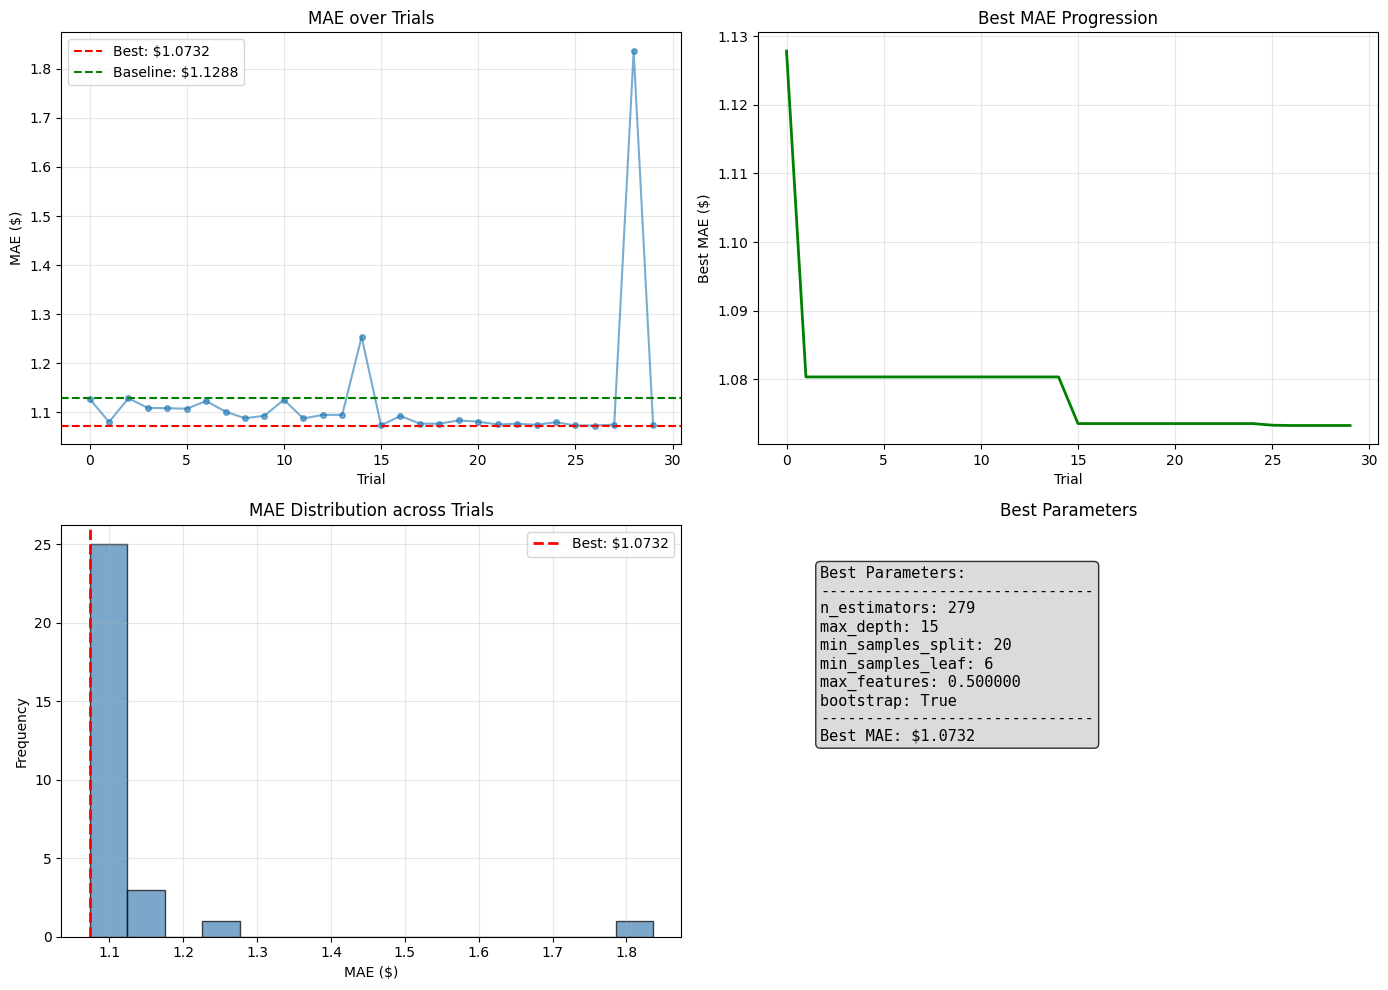

✅ Saved: ../models/optuna_optimization.png


In [26]:
# Manual visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE over trials
ax1 = axes[0, 0]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
ax1.plot(trial_numbers, trial_values, 'o-', alpha=0.6, markersize=4)
ax1.axhline(y=best_trial.value, color='red', linestyle='--', label=f'Best: ${best_trial.value:.4f}')
if BASELINE_VAL_MAE:
    ax1.axhline(y=BASELINE_VAL_MAE, color='green', linestyle='--', label=f'Baseline: ${BASELINE_VAL_MAE:.4f}')
ax1.set_xlabel('Trial')
ax1.set_ylabel('MAE ($)')
ax1.set_title('MAE over Trials')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Best MAE progression
ax2 = axes[0, 1]
best_values = [min(trial_values[:i+1]) for i in range(len(trial_values))]
ax2.plot(trial_numbers, best_values, 'g-', linewidth=2)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Best MAE ($)')
ax2.set_title('Best MAE Progression')
ax2.grid(alpha=0.3)

# 3. MAE distribution
ax3 = axes[1, 0]
ax3.hist(trial_values, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(x=best_trial.value, color='red', linestyle='--', linewidth=2, label=f'Best: ${best_trial.value:.4f}')
ax3.set_xlabel('MAE ($)')
ax3.set_ylabel('Frequency')
ax3.set_title('MAE Distribution across Trials')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Top parameters box
ax4 = axes[1, 1]
ax4.axis('off')
param_text = "Best Parameters:\n" + "-"*30 + "\n"
for key, value in best_trial.params.items():
    if isinstance(value, float):
        param_text += f"{key}: {value:.6f}\n"
    else:
        param_text += f"{key}: {value}\n"
param_text += "-"*30 + f"\nBest MAE: ${best_trial.value:.4f}"
ax4.text(0.1, 0.9, param_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
ax4.set_title('Best Parameters')

plt.tight_layout()
plt.savefig(MODELS_DIR / 'optuna_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {MODELS_DIR / 'optuna_optimization.png'}")


## 8. Train Final Model with Best Parameters

In [27]:
# Get best parameters
best_params = best_trial.params.copy()
best_params['random_state'] = 42
best_params['n_jobs'] = -1

print("📋 Best Parameters for Final Model:")
for k, v in best_params.items():
    print(f"   {k}: {v}")


📋 Best Parameters for Final Model:
   n_estimators: 279
   max_depth: 15
   min_samples_split: 20
   min_samples_leaf: 6
   max_features: 0.5
   bootstrap: True
   random_state: 42
   n_jobs: -1


In [28]:
# Train final model on FULL training data
print("\n🚀 Training final model on full data...")

if MODEL_TO_TUNE == 'random_forest':
    final_model = RandomForestRegressor(**best_params)
elif MODEL_TO_TUNE == 'lightgbm':
    final_model = lgb.LGBMRegressor(**best_params)
elif MODEL_TO_TUNE == 'xgboost':
    final_model = xgb.XGBRegressor(**best_params)
else:
    final_model = GradientBoostingRegressor(**best_params)

start_time = time.time()
final_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"✅ Training complete in {train_time:.2f}s")



🚀 Training final model on full data...
✅ Training complete in 3590.25s


In [29]:
# Evaluate on all sets
def evaluate_model(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'r2': r2_score(y_true, y_pred)
    }

# Predictions
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

# Metrics
train_metrics = evaluate_model(y_train, y_train_pred)
val_metrics = evaluate_model(y_val, y_val_pred)
test_metrics = evaluate_model(y_test, y_test_pred)

print("📊 Final Model Performance:")
print("\n   Train:")
print(f"      MAE:  ${train_metrics['mae']:.4f}")
print(f"      RMSE: ${train_metrics['rmse']:.4f}")
print(f"      R²:   {train_metrics['r2']:.4f}")

print("\n   Validation:")
print(f"      MAE:  ${val_metrics['mae']:.4f}")
print(f"      RMSE: ${val_metrics['rmse']:.4f}")
print(f"      R²:   {val_metrics['r2']:.4f}")

print("\n   Test:")
print(f"      MAE:  ${test_metrics['mae']:.4f}")
print(f"      RMSE: ${test_metrics['rmse']:.4f}")
print(f"      R²:   {test_metrics['r2']:.4f}")


📊 Final Model Performance:

   Train:
      MAE:  $0.9780
      RMSE: $3.0551
      R²:   0.9676

   Validation:
      MAE:  $0.9999
      RMSE: $3.2257
      R²:   0.9641

   Test:
      MAE:  $1.0026
      RMSE: $3.2155
      R²:   0.9643


## 9. Log to MLflow

In [30]:
# Log final model to MLflow
with mlflow.start_run(run_name=f"{MODEL_TO_TUNE}_tuned"):
    # Log parameters
    mlflow.log_params(best_params)
    mlflow.log_param('tuning_trials', len(study.trials))
    mlflow.log_param('tuning_time_minutes', total_time / 60)
    
    # Log metrics
    for name, value in train_metrics.items():
        mlflow.log_metric(f'train_{name}', value)
    for name, value in val_metrics.items():
        mlflow.log_metric(f'val_{name}', value)
    for name, value in test_metrics.items():
        mlflow.log_metric(f'test_{name}', value)
    
    # Log model
    mlflow.sklearn.log_model(final_model, "model")
    
    # Log artifacts
    mlflow.log_artifact(MODELS_DIR / 'optuna_optimization.png')
    
    run_id = mlflow.active_run().info.run_id
    print(f"✅ Logged to MLflow (run_id: {run_id[:8]}...)")


2025/12/13 07:55:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged to MLflow (run_id: 5f009fa1...)


## 10. Save Tuned Model

In [31]:
# Save tuned model
tuned_model_path = MODELS_DIR / 'tuned_model.joblib'
joblib.dump(final_model, tuned_model_path)
print(f"✅ Saved tuned model: {tuned_model_path}")

# Save tuned model metadata
tuned_metadata = {
    'model_name': MODEL_TO_TUNE,
    'model_type': 'tuned',
    'best_params': best_params,
    'optuna_trials': len(study.trials),
    'optuna_best_trial': best_trial.number,
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'features': ALL_FEATURES,
    'target': TARGET,
    'mlflow_run_id': run_id
}

tuned_metadata_path = MODELS_DIR / 'tuned_model_metadata.joblib'
joblib.dump(tuned_metadata, tuned_metadata_path)
print(f"✅ Saved metadata: {tuned_metadata_path}")


✅ Saved tuned model: ../models/tuned_model.joblib
✅ Saved metadata: ../models/tuned_model_metadata.joblib


In [32]:
# Save Optuna study
study_path = MODELS_DIR / 'optuna_study.joblib'
joblib.dump(study, study_path)
print(f"✅ Saved Optuna study: {study_path}")


✅ Saved Optuna study: ../models/optuna_study.joblib


## 11. Compare Before vs After Tuning

In [33]:
# Load baseline model for comparison
try:
    baseline_model = joblib.load(MODELS_DIR / 'best_model.joblib')
    baseline_metadata = joblib.load(MODELS_DIR / 'model_metadata.joblib')
    
    # Evaluate baseline on test set
    y_baseline_pred = baseline_model.predict(X_test)
    baseline_test_metrics = evaluate_model(y_test, y_baseline_pred)
    
    # Comparison
    print("📊 Before vs After Tuning (Test Set):")
    print("="*60)
    print(f"{'Metric':<10} {'Baseline':>15} {'Tuned':>15} {'Improvement':>15}")
    print("-"*60)
    
    for metric in ['mae', 'rmse', 'r2']:
        baseline_val = baseline_test_metrics[metric]
        tuned_val = test_metrics[metric]
        
        if metric == 'r2':
            improvement = tuned_val - baseline_val
            print(f"{metric.upper():<10} {baseline_val:>15.4f} {tuned_val:>15.4f} {improvement:>+15.4f}")
        else:
            improvement = baseline_val - tuned_val
            print(f"{metric.upper():<10} ${baseline_val:>14.4f} ${tuned_val:>14.4f} ${improvement:>+14.4f}")
    
    print("="*60)
    
except FileNotFoundError:
    print("⚠️ No baseline model found for comparison")


📊 Before vs After Tuning (Test Set):
Metric            Baseline           Tuned     Improvement
------------------------------------------------------------
MAE        $        1.1140 $        1.0026 $       +0.1114
RMSE       $        3.5899 $        3.2155 $       +0.3744
R2                  0.9556          0.9643         +0.0088


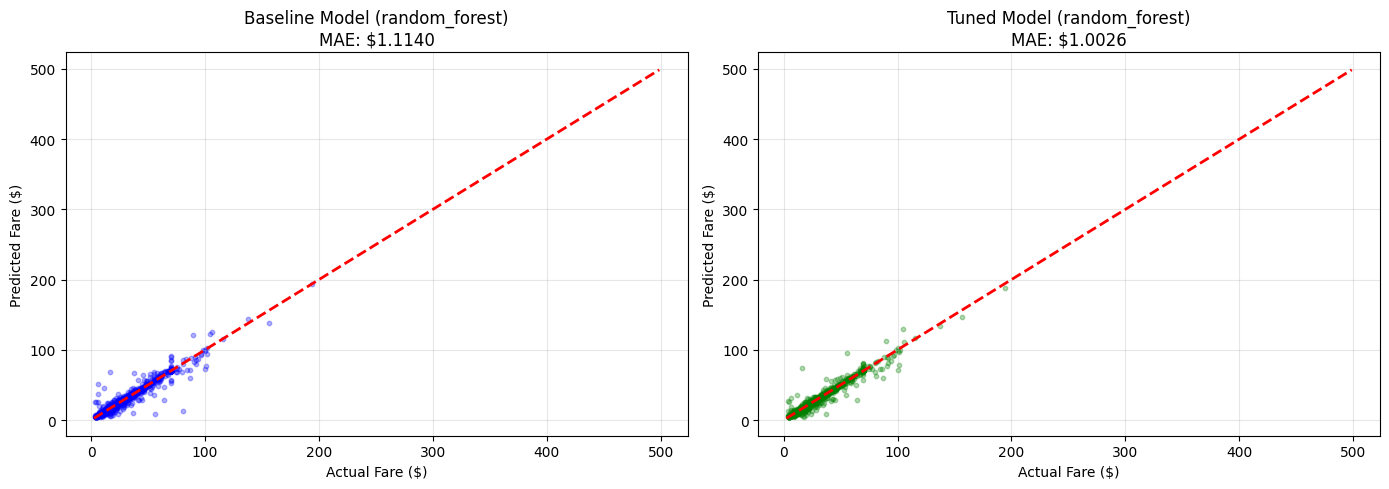

✅ Saved: ../models/baseline_vs_tuned.png


In [34]:
# Visual comparison
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sample for plotting
    sample_size = min(3000, len(y_test))
    sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
    y_test_sample = y_test.iloc[sample_idx]
    y_baseline_sample = y_baseline_pred[sample_idx]
    y_tuned_sample = y_test_pred[sample_idx]
    
    # Baseline predictions
    ax1 = axes[0]
    ax1.scatter(y_test_sample, y_baseline_sample, alpha=0.3, s=10, c='blue')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Fare ($)')
    ax1.set_ylabel('Predicted Fare ($)')
    ax1.set_title(f'Baseline Model ({baseline_metadata["model_name"]})\nMAE: ${baseline_test_metrics["mae"]:.4f}')
    ax1.grid(alpha=0.3)
    
    # Tuned predictions
    ax2 = axes[1]
    ax2.scatter(y_test_sample, y_tuned_sample, alpha=0.3, s=10, c='green')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual Fare ($)')
    ax2.set_ylabel('Predicted Fare ($)')
    ax2.set_title(f'Tuned Model ({MODEL_TO_TUNE})\nMAE: ${test_metrics["mae"]:.4f}')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'baseline_vs_tuned.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {MODELS_DIR / 'baseline_vs_tuned.png'}")
    
except NameError:
    print("⚠️ Baseline model not available for comparison plot")


## 12. Summary

In [35]:
print("="*70)
print("                📋 HYPERPARAMETER TUNING SUMMARY")
print("="*70)

print(f"""
OPTUNA OPTIMIZATION:
   Model: {MODEL_TO_TUNE}
   Trials: {len(study.trials)}
   Best Trial: #{best_trial.number}
   Optimization Time: {total_time/60:.1f} minutes

BEST PARAMETERS:
""")
for k, v in best_params.items():
    if isinstance(v, float):
        print(f"   {k}: {v:.6f}")
    else:
        print(f"   {k}: {v}")

print(f"""
FINAL MODEL PERFORMANCE:
   Train MAE:  ${train_metrics['mae']:.4f}
   Val MAE:    ${val_metrics['mae']:.4f}
   Test MAE:   ${test_metrics['mae']:.4f}
   Test R²:    {test_metrics['r2']:.4f}
""")

if BASELINE_VAL_MAE:
    improvement = BASELINE_VAL_MAE - val_metrics['mae']
    print(f"IMPROVEMENT:")
    print(f"   Baseline MAE: ${BASELINE_VAL_MAE:.4f}")
    print(f"   Tuned MAE:    ${val_metrics['mae']:.4f}")
    print(f"   Improvement:  ${improvement:.4f} ({(improvement/BASELINE_VAL_MAE)*100:.2f}%)")

print(f"""
SAVED FILES:
   📁 {MODELS_DIR}/
      - tuned_model.joblib
      - tuned_model_metadata.joblib
      - optuna_study.joblib
      - optuna_optimization.png
      - baseline_vs_tuned.png
""")

print("="*70)
print("✅ Hyperparameter Tuning Complete!")
print("   Next: 05_model_evaluation.ipynb")
print("="*70)


                📋 HYPERPARAMETER TUNING SUMMARY

OPTUNA OPTIMIZATION:
   Model: random_forest
   Trials: 30
   Best Trial: #26
   Optimization Time: 7.5 minutes

BEST PARAMETERS:

   n_estimators: 279
   max_depth: 15
   min_samples_split: 20
   min_samples_leaf: 6
   max_features: 0.500000
   bootstrap: True
   random_state: 42
   n_jobs: -1

FINAL MODEL PERFORMANCE:
   Train MAE:  $0.9780
   Val MAE:    $0.9999
   Test MAE:   $1.0026
   Test R²:    0.9643

IMPROVEMENT:
   Baseline MAE: $1.1288
   Tuned MAE:    $0.9999
   Improvement:  $0.1289 (11.42%)

SAVED FILES:
   📁 ../models/
      - tuned_model.joblib
      - tuned_model_metadata.joblib
      - optuna_study.joblib
      - optuna_optimization.png
      - baseline_vs_tuned.png

✅ Hyperparameter Tuning Complete!
   Next: 05_model_evaluation.ipynb


---

## 🔗 Next Steps

1. **05_model_evaluation.ipynb** - Detailed error analysis & evaluation
2. **Deploy API** - Serve tuned model via FastAPI
3. **Monitor** - Setup Evidently for drift detection